# Computer Vision - Assignment 0

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import scipy
from torch.autograd import Variable


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## 1. Introduction

The purpose of this assignment is two-fold: (i) to ensure that you have the pre-requisite knowledge necessary
for the rest of the course and (ii) to help you get experience with PyTorch, the language we will be using in
the course.
To install PyTorch, follow the directions at http://pytorch.org. This also contains a number of tutorials
that it might be helpful to work through.

## 2. Whitening Data

Pre-processing is an important part of computer vision and machine learning algorithms. One common approach is known as whitening in which the data is transformed so that it has zero mean and is decorrelated.
You should implement a PyTorch function that:

* Load up the 2D dataset from the file assign0_data.py

In [3]:
def load_data(filename):
    return torch.load(filename)

In [4]:
data = load_data("./assign0_data.py")

In [5]:
data


 2.0481 -2.4186
 2.3295 -2.3656
 2.1563 -2.2842
       ⋮        
 2.1631 -2.3214
 2.2425 -2.0835
 2.3117 -2.2227
[torch.FloatTensor of size 629x2]

* Visualize it by making a 2D scatter plot (e.g. using matplotlib).

In [42]:
def plot2DTorchTensor(dataObj):
    plt.scatter(data[:,0].numpy(), data[:,1].numpy(), alpha=0.7)
    plt.title('2D tensor plot')
    plt.show()

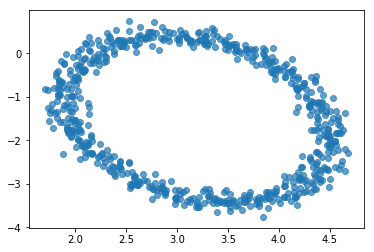

In [7]:
plot2DTorchTensor(data)

* Translate the data so that it has zero mean (i.e. is centered at the origin).

In [38]:
def center2DTensor(data):
    mean_x = torch.mean(data[:,0])
    mean_y = torch.mean(data[:,1])
    centered = torch.stack([data[:,0]-mean_x, data[:,1]-mean_y], 1)
    plt.scatter(centered[:,0].numpy(), centered[:,1].numpy(), alpha=0.7)
    plt.title('Centered data')
    plt.show()
    return centered


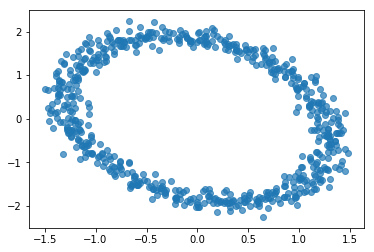

In [9]:
centered = center2DTensor(data)
plt.scatter(centered[:,0].numpy(), centered[:,1].numpy(), alpha=0.7)
plt.show()

* Decorrelates the data so that the data covariance is the identity matrix

In [10]:
sigma = np.cov(data.numpy().T)
sigma

array([[ 0.85428844, -0.29943774],
       [-0.29943774,  1.83969226]])

In [11]:
w, v = np.linalg.eig(sigma)
v_trans = v.T
v_trans

array([[-0.96295345, -0.26966767],
       [ 0.26966767, -0.96295345]])

In [12]:
d = np.linalg.inv(v).dot(sigma).dot(v)
transformer_matrix = scipy.linalg.fractional_matrix_power(d, -0.5).dot(v_trans)
transformer_matrix

array([[-1.09707873, -0.30722842],
       [ 0.19443634, -0.69431067]])

In [13]:
y = transformer_matrix.dot(data.numpy().T)
y.shape
np.cov(y)

array([[  1.00000000e+00,   6.78862486e-17],
       [  6.78862486e-17,   1.00000000e+00]])

Below is the data covariance matrix. Accounting for machine precision error, it is a an identity matrix

In [14]:
decorrelated = y.T
np.cov(y)

array([[  1.00000000e+00,   6.78862486e-17],
       [  6.78862486e-17,   1.00000000e+00]])

In [41]:
def decorr(data):
    sigma = np.cov(data.numpy().T)
    w, v = np.linalg.eig(sigma)
    v_trans = v.T
    d = np.linalg.inv(v).dot(sigma).dot(v)
    transformer_matrix = scipy.linalg.fractional_matrix_power(d, -0.5).dot(v_trans)
    decorrelated = transformer_matrix.dot(data.numpy().T)
    decorrelated = decorrelated.T
    plt.scatter(decorrelated[:,0], decorrelated[:,1], alpha=0.7)
    plt.title('Whitened data')
    plt.show()
    return decorrelated

* Plot the whitened data

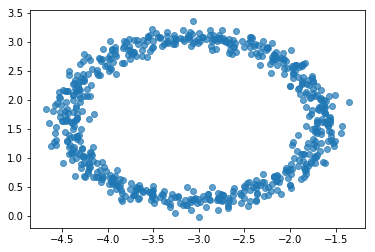

In [16]:
plt.scatter(decorrelated[:,0], decorrelated[:,1], alpha=0.7)
plt.show()

* As a comment in your code, discuss the dependencies present in the whitened data

Whitening only got rid of linear dependencies in the data. By plotting the whitened data, we can easily see that the data still has non-linear / higher-order dependencies. Looking at the graph, it appears that the dependency is quadratic in nature.

In [43]:
def whitening_function (filename):
    data = load_data(filename)
    plot2DTorchTensor(data)
    centered = center2DTensor(data)
    decorred = decorr(centered)

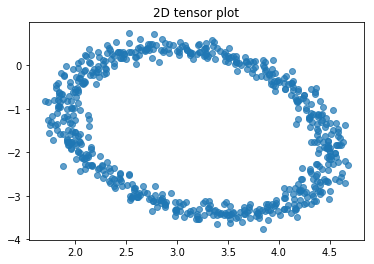

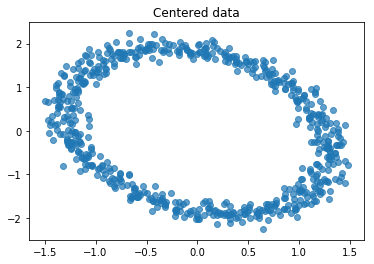

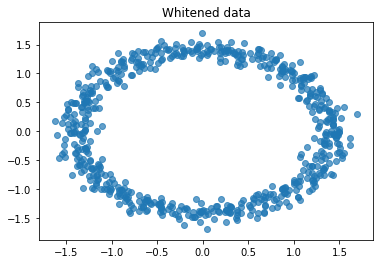

In [44]:
whitening_function("assign0_data.py")

## 3. Fitting a 1D function with a simple neural net

In PyTorch, generate the function $y = cos(x)$ over the interval $−π ≤ x ≤ π$, at discrete intervals of 0.01.
Adapting the examples from http://pytorch.org/tutorials/beginner/pytorch_with_examples.html,
implement a neural net that regresses this function. I.e. takes as input $x$ and produces an estimate $\hat{y}$, where
$\vert\vert y − \hat{y}\vert\vert _{2}$ is minimized. The network should have a single hidden layer with 10 units and a single $tanh()$ non-linearity. Make a plot of the true function $y$, with the network output $\hat{y}$ before and after training overlaid (please use different colors for each).

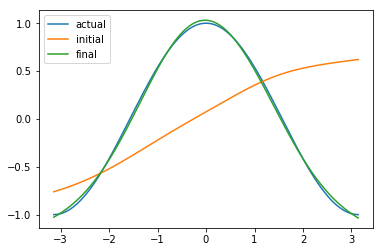

In [2]:
dtype = torch.FloatTensor
x = Variable(torch.arange(-np.pi, np.pi, 0.01).type(dtype), requires_grad=False)
x = x.view(x.size()[0], 1)
y = Variable(torch.cos(x.data).type(dtype), requires_grad=False)
N, D_in, H, D_out = x.size()[0], 1, 10, 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Tanh(),
    torch.nn.Linear(H, D_out),
)

plt.clf()
plt.plot(x.data.numpy(), y.data.numpy(), label="actual")

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
for t in range(500):
    y_pred = model(x)
    
    
    if (t == 0):
        plt.plot(x.data.numpy(), y_pred.data.numpy(), label="initial")
        
    elif (t == 499):
        new_y = y_pred.data.numpy
        plt.plot(x.data.numpy(), y_pred.data.numpy(), label="final")
    

    loss = loss_fn(y_pred, y)
    model.zero_grad()

    loss.backward()

    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

plt.legend(loc='best')
plt.show()